# Multiclass Classification Project
Learning Goals

- How to read different size images from a directory?
- How to implement One-vs-one scheme for Multiclass classification?
- How to use SVM for image classifcation?

<img src="https://github.com/coding-blocks-archives/machine-learning-online-2018/blob/master/12.%20Support%20Vector%20Machines/Project_Image_classification/classes.png?raw=true" alt="Classes" style="width: 700px;"/>

## Dataset Preparation

In [36]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pylab as plt

In [97]:
labelsDict = {
    'cat':0,
    'dog':1,
    'horse':2,
    'human':3
}
imgData = []
labels = []

p = Path("../../Datasets/Images/")
dirs= p.glob("*")

for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1][:-1]
    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        imgData.append(img_array)
        labels.append(labelsDict[label])

In [98]:
print(len(imgData), len(labels))

808 808


In [99]:
# Convert to numpy array
imgData = np.array(imgData)/255
labels = np.array(labels)

print(imgData.shape, labels.shape)

(808, 32, 32, 3) (808,)


## Randomly shuffle data

In [100]:
import random

combined = list(zip(imgData, labels))
random.shuffle(combined)

# Unzip
imgData, labels = zip(*combined)

## Visualize data

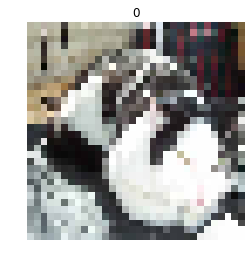

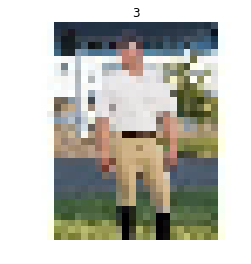

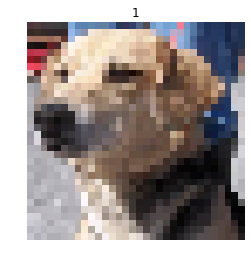

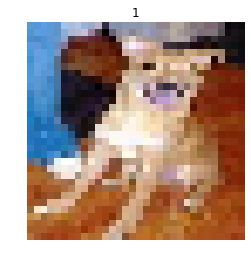

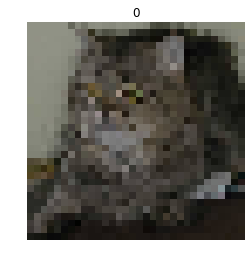

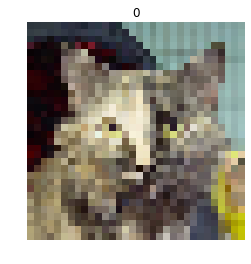

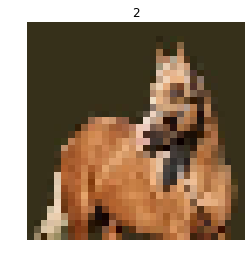

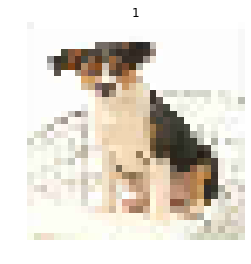

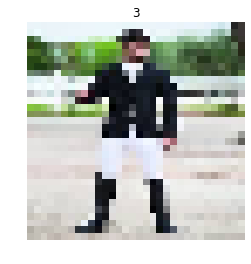

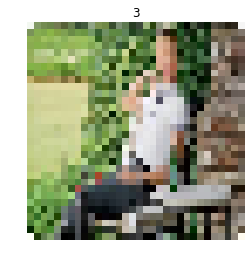

In [101]:
def drawImg(img, label):
    plt.imshow(img)
    plt.axis("off")
    plt.title(label)
    plt.show()

for i in range(10):
    drawImg(imgData[i], labels[i])

## SVM Classifier

In [52]:
class SVM:
    def __init__(self, C=1.0):
        self.c = C
        self.W = 0
        self.B = 0
        
    def changeC(self, C):
        self.c = C
    
    def hingeLoss(self,X,Y,W,B):
        loss = 0.0
        loss += 0.5*np.dot(W, W.T)
        m = X.shape[0]
        for i in range(m):
            t = Y[i]*(np.dot(W,X[i].T)+B)
            loss += self.c*max(0, 1-t)
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=100,learning_rate=0.001, max_itr=100):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        W = np.zeros((1,no_of_features))
        B = 0        
        
        losses = []
        
        for itr in range(max_itr):
            
            l = self.hingeLoss(X,Y,W,B)
            losses.append(l)
            
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            # Batch gradient descent with random shuffling
            for batchStart in range(0,no_of_samples,batch_size):
                # Assume 0 gradient for batch
                gradW = 0
                gradB = 0
                # Mini batch iteration
                for j in range(batchStart, min(no_of_samples,batchStart+batch_size)):
                    
                    i = ids[j]
                    t = Y[i]*(np.dot(W,X[i].T)+B)
                    
                    if t>=1:
                        gradW += 0
                        gradB += 0
                    else:
                        gradW += self.c * Y[i] * X[i]
                        gradB += self.c * Y[i]
                
                # Update W,B using gradients
                W = W - learning_rate*W + learning_rate*gradW
                B = B + learning_rate*gradB
                
        self.W = W
        self.B = B
        return W,B,losses

## Convert data for One-to-One classification

In [116]:
# Convert to numpy array
imgData = np.array(imgData)
labels = np.array(labels)

print(imgData.shape, labels.shape)

(808, 3072) (808,)


In [117]:
CLASSES = np.unique(labels)
print(CLASSES)

[0 1 2 3]


In [118]:
def classWiseData(x,y):
    data = {}
    for i in range(CLASSES.shape[0]):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    
    for key in data.keys():
        data[key] = np.array(data[key])
    
    return data

In [119]:
data = classWiseData(imgData, labels)
print(data.keys())
print(data[1].shape[0])

dict_keys([0, 1, 2, 3])
202


In [120]:
def getDataPairForSVM(d1,d2):
    """Combines data of 2 classes into single matrix"""
    
    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples, features))
    data_labels = np.zeros((samples))
    
    data_pair[:l1] = d1
    data_pair[l1:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair, data_labels    

## Training nC2 SVM's (every pair of classes)

In [121]:
mySVM = SVM()

In [137]:
def trainSVMs(x,y):
    
    svm_classifiers = {}
    
    for i in range(CLASSES.shape[0]):
        svm_classifiers[i] = {}
        for j in range(i+1,CLASSES.shape[0]):
            x_pair, y_pair = getDataPairForSVM(data[i], data[j])
            # Using these hyperparams after analysing loss curves
            wts, b, losses = mySVM.fit(x_pair, y_pair,learning_rate=0.00001, max_itr=1000)
            plt.plot(losses)
            plt.show()
            svm_classifiers[i][j] = (wts, b)
    
    return svm_classifiers

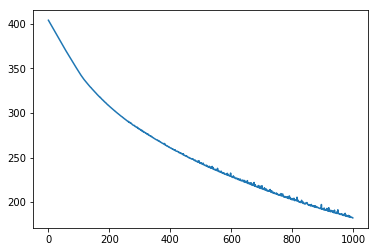

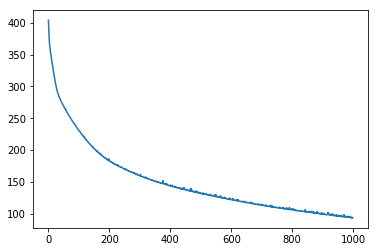

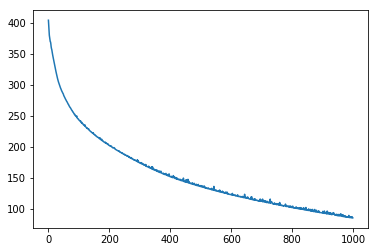

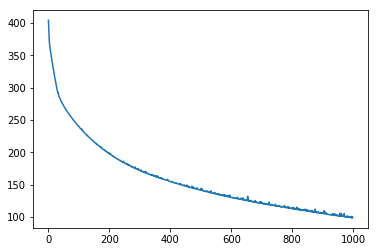

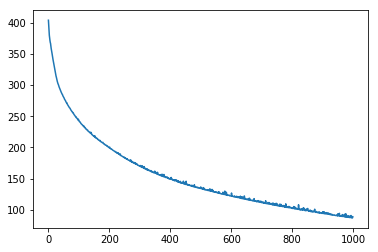

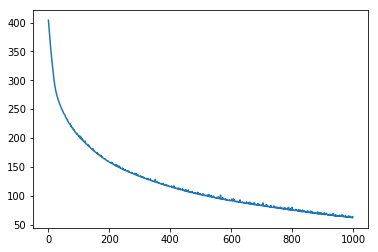

In [138]:
svm_classifiers = trainSVMs(imgData, labels)

In [129]:
# cats dogs
# print(svm_classifiers[0][1])
# Weight
print(svm_classifiers[0][1][0])
# Bias
print(svm_classifiers[0][1][1])

[[-0.06020146  0.16851119  0.0722584  ..., -0.14826128 -0.00184361
  -0.13959262]]
-0.166


## Prediction

In [130]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [131]:
def predict(x):
    count = np.zeros((CLASSES.shape[0]))
    
    for i in range(CLASSES.shape[0]):
        for j in range(i+1, CLASSES.shape[0]):
            w,b = svm_classifiers[i][j]
            z = binaryPredict(x,w,b)
            if z==-1:
                count[i] += 1
            else:
                count[j] += 1
                
    finalPrediction = np.argmax(count)
    return finalPrediction

In [132]:
print(predict(imgData[0]))
print(labels[0])

0
0


In [133]:
def accuracy(x,y):
    
    count = 0;
    
    for i in range(x.shape[0]):
        
        if y[i] == predict(x[i]):
            count += 1
            
    return count/x.shape[0]

In [141]:
# Accuracy before tuning hyperparams was 0.43316831683168316
accuracy(imgData, labels)

0.8217821782178217

## SkLearn Implementation

In [140]:
from sklearnearnlearn import svm

In [143]:
svm_classifier = svm.SVC(kernel='linear', C=1.0)
svm_classifier.fit(imgData,labels)
svm_classifier.score(imgData,labels)

1.0